# MLP - Titanic

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# We are reading a clean dataset from titanic generated from 05-dm-filtering.ipynb

df = pd.read_csv("../data/processed/titanic-clean.csv")
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [3]:
df.shape

(889, 11)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Categorical Features

In [5]:
select_features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Fare"]
categorical_features = ["Pclass", "Sex"]

In [6]:
df = df[select_features]
df.head()

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250
3,1,1,female,35.0,1,53.1000
4,0,3,male,35.0,0,8.0500


## One-Hot-Encoder

In [7]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoder.fit(df[categorical_features])
one_hot_encoder

OneHotEncoder(handle_unknown='ignore')

In [8]:
# retrieving the column names from the OneHotEncoder

column_names = one_hot_encoder.get_feature_names_out(categorical_features)
column_names

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male'],
      dtype=object)

In [9]:
# applying the one-hot-encoder on the categorical columns

transformed_data = one_hot_encoder.transform(df[categorical_features])
transformed_data

<889x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1778 stored elements in Compressed Sparse Row format>

In [10]:
# Converting the sparse matrix to dataframe

df_transformed = pd.DataFrame.sparse.from_spmatrix(transformed_data,
                                                   columns=column_names)
df_transformed

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,0,1.0,0,1.0
1,1.0,0,0,1.0,0
2,0,0,1.0,1.0,0
3,1.0,0,0,1.0,0
4,0,0,1.0,0,1.0
...,...,...,...,...,...
884,0,1.0,0,0,1.0
885,1.0,0,0,1.0,0
886,0,0,1.0,1.0,0
887,1.0,0,0,0,1.0


In [11]:
# extracting only the columns that didnt need to be encoded

df = df.drop(columns=categorical_features)
df.head()

,Survived,Age,SibSp,Fare
0,0,22.0,1,7.2500
1,1,38.0,1,71.2833
2,1,26.0,0,7.9250
3,1,35.0,1,53.1000
4,0,35.0,0,8.0500


In [12]:
# merging/joing the transformed data frame with categorical data with a datafram containing non-categorical features

final_df = df.join(df_transformed)
final_df.head()

,Survived,Age,SibSp,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22.0,1,7.2500,0,0,1.0,0,1.0
1,1,38.0,1,71.2833,1.0,0,0,1.0,0
2,1,26.0,0,7.9250,0,0,1.0,1.0,0
3,1,35.0,1,53.1000,1.0,0,0,1.0,0
4,0,35.0,0,8.0500,0,0,1.0,0,1.0


In [13]:
final_df.dtypes

Survived                   int64
Age                      float64
SibSp                      int64
Fare                     float64
Pclass_1      Sparse[float64, 0]
Pclass_2      Sparse[float64, 0]
Pclass_3      Sparse[float64, 0]
Sex_female    Sparse[float64, 0]
Sex_male      Sparse[float64, 0]
dtype: object

## Converting Sparse into Int

In [14]:
final_df[column_names] = final_df[column_names].sparse.to_dense()

In [15]:
conversion = {}
for col in column_names:
    conversion[col] = 'int8'

final_df = final_df.astype(conversion)

In [16]:
final_df.dtypes

Survived        int64
Age           float64
SibSp           int64
Fare          float64
Pclass_1         int8
Pclass_2         int8
Pclass_3         int8
Sex_female       int8
Sex_male         int8
dtype: object

## Scaling

In [17]:
final_df.describe()

,Survived,Age,SibSp,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,29.535624,0.524184,32.096681,0.240720,0.206974,0.552306,0.350956,0.649044
std,0.486260,14.527483,1.103705,49.697504,0.427761,0.405365,0.497536,0.477538,0.477538
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,38.000000,1.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,80.000000,8.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


### MinMaxScaler

If we have a series of data between 0 and 10
We can simply divide them all by 10 to have values between 0 and 1.

Now, if the data is spread between 10 and 20, then we need to shift data
by 10 units to make them first between 0 and 10, then divide them all by 10.

**Formula:**

$MinMaxScaler = \frac{x - min}{max - min}$

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [18]:
columns_to_scale = ["Age", "SibSp", "Fare"]

scaler = MinMaxScaler(clip=True)
final_df[columns_to_scale] = scaler.fit_transform(final_df[columns_to_scale])

final_df.head()

,Survived,Age,SibSp,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,0.271174,0.125,0.014151,0,0,1,0,1
1,1,0.472229,0.125,0.139136,1,0,0,1,0
2,1,0.321438,0.000,0.015469,0,0,1,1,0
3,1,0.434531,0.125,0.103644,1,0,0,1,0
4,0,0.434531,0.000,0.015713,0,0,1,0,1


In [19]:
final_df.describe()

,Survived,Age,SibSp,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,0.365866,0.065523,0.062649,0.240720,0.206974,0.552306,0.350956,0.649044
std,0.486260,0.182552,0.137963,0.097003,0.427761,0.405365,0.497536,0.477538,0.477538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.246042,0.000000,0.015412,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.346569,0.000000,0.028213,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,0.472229,0.125000,0.060508,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# Testing with Age: 100, SibSp: 7, Fare: 250
# Since clip = True, Age will be transformed to 1
# eventhough the maximum age = 80

scaler.transform([[100, 7, 250]])

C:\Users\Kaveh\miniconda3\envs\ai\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[1.       , 0.875    , 0.4879675]])

## Train / Test Split

In [21]:
X = final_df.drop(columns=["Survived"])
y = final_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
X_train.shape

(711, 8)

In [23]:
X_test.shape

(178, 8)

## Training

In [30]:
# Fitting model based on the train data
model = MLPClassifier(hidden_layer_sizes=(10, 10, ),
                     max_iter=1000,
                     verbose=True,
                     solver="adam",
                     n_iter_no_change=100,
                     early_stopping=True)
model.fit(X_train, y_train)

Iteration 1, loss = 0.66608975
Validation score: 0.625000
Iteration 2, loss = 0.66261049
Validation score: 0.625000
Iteration 3, loss = 0.65924916
Validation score: 0.625000
Iteration 4, loss = 0.65605795
Validation score: 0.625000
Iteration 5, loss = 0.65290390
Validation score: 0.625000
Iteration 6, loss = 0.64995986
Validation score: 0.625000
Iteration 7, loss = 0.64692814
Validation score: 0.625000
Iteration 8, loss = 0.64412826
Validation score: 0.625000
Iteration 9, loss = 0.64155198
Validation score: 0.625000
Iteration 10, loss = 0.63905606
Validation score: 0.625000
Iteration 11, loss = 0.63664144
Validation score: 0.625000
Iteration 12, loss = 0.63400538
Validation score: 0.625000
Iteration 13, loss = 0.63162106
Validation score: 0.625000
Iteration 14, loss = 0.62910016
Validation score: 0.625000
Iteration 15, loss = 0.62660606
Validation score: 0.625000
Iteration 16, loss = 0.62400425
Validation score: 0.625000
Iteration 17, loss = 0.62160793
Validation score: 0.625000
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(10, 10), max_iter=1000,
              n_iter_no_change=100, verbose=True)

In [33]:
loss_curve = model.loss_curve_
loss_curve

[0.6660897502668406,
 0.6626104861509101,
 0.659249163277324,
 0.6560579486380458,
 0.6529038952292032,
 0.6499598576623735,
 0.6469281375317159,
 0.6441282624844779,
 0.6415519769517888,
 0.6390560575216352,
 0.6366414403478385,
 0.6340053834179167,
 0.6316210559486531,
 0.6291001633952983,
 0.6266060637157914,
 0.624004251952843,
 0.6216079322136928,
 0.6189825064176215,
 0.6165360230210628,
 0.6140778316298577,
 0.6114469451212982,
 0.608967431781825,
 0.6063062954252081,
 0.6037433169741196,
 0.6012416926855411,
 0.5986294383749252,
 0.5960537937668222,
 0.593581071215809,
 0.5911000850355318,
 0.5887074693085211,
 0.586448321359576,
 0.5844874097596598,
 0.5824935050329276,
 0.5804886825252684,
 0.5785059193937062,
 0.5763873959329914,
 0.5745353114922466,
 0.5725968557602223,
 0.5709018896025448,
 0.5693406400033469,
 0.567907956148238,
 0.5664466993897543,
 0.5650263172031028,
 0.5637034517195936,
 0.5621953580699774,
 0.5608852279065264,
 0.5596013857435598,
 0.558531044786715,

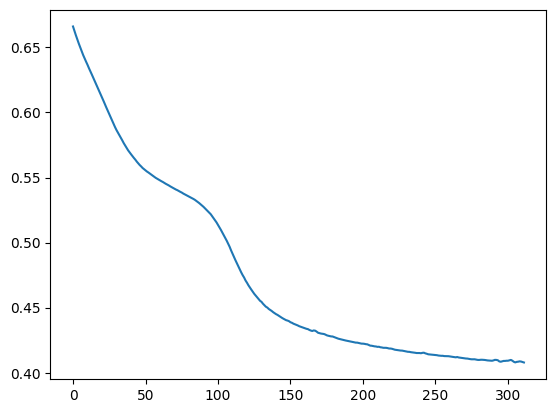

In [34]:
plt.plot(loss_curve)
plt.show()

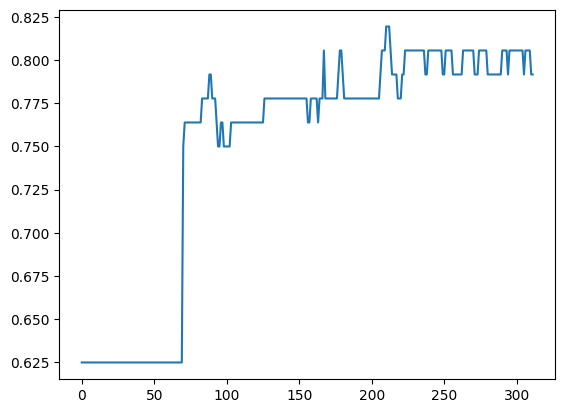

In [35]:
validation_scores = model.validation_scores_

plt.plot(validation_scores)
plt.show()

### Accuracy

In [36]:
model.score(X_test, y_test)

0.8033707865168539

In [37]:
predictions = model.predict(X_test)
predictions

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1], dtype=int64)

In [38]:
y_test.values

array([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1], dtype=int64)

In [39]:
correct = 0
wrong = 0
for i in range(len(y_test)):
    if predictions[i] == y_test.values[i]:
        correct += 1
    else:
        wrong += 1

correct, wrong

(143, 35)

In [40]:
import numpy as np

In [41]:

np.absolute(predictions - y_test.values).sum()

35

### Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [43]:
model.classes_

array([0, 1], dtype=int64)

In [44]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
cm

array([[94, 15],
       [20, 49]], dtype=int64)

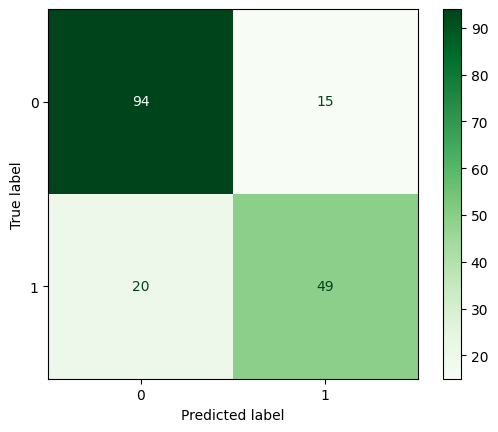

In [46]:
disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
disp.plot(cmap="Greens")
plt.show()

In [47]:
from sklearn.metrics import f1_score

In [48]:
from sklearn.metrics import f1_score

In [49]:
f1_score(y_test, predictions)

0.7368421052631579

## Saving Model

In [50]:
model.feature_names_in_

array(['Age', 'SibSp', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'], dtype=object)

In [53]:
import pickle

In [ ]:
with open("../object/titanic-model.pickle", "wb") as f:
    pickle.dump(model, f)

with open("../object/titanic-encoder.pickle", "wb") as f:
    pickle.dump(one_hot_encoder, f)

with open("../object/titanic-scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
with open("model.pickle", "rb") as f:
    new_model = pickle.load(f)

new_model

In [ ]:
new_model.predict_proba([test_record])